In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

Running the notebook `save_iris_dataset.ipynb` generated many files in `./gaze_dataset`.  
I manually split the samples into two folders: `./gaze_dataset/train` and `./gaze_dataset/test`.

#### Dataset Loading TRAIN samples


In [13]:
# Dataset params
num_classes = 100
SAVE_DIR_TRAIN = "./gaze_dataset/train"

x_train = []
y_train = []

for filename in os.listdir(SAVE_DIR_TRAIN):
    if not filename.endswith(".npy"):
        continue

    # filename: cell_{row}_{col}_{timestamp}.npy
    parts = filename[:-4].split("_")
    if len(parts) < 4 or parts[0] != "cell":
        continue  # skip no datasets files

    row = int(parts[1])
    col = int(parts[2])
    label = row * 10 + col

    filepath = os.path.join(SAVE_DIR_TRAIN, filename)
    data = np.load(filepath)

    # додаємо канал для Conv2D
    data = np.expand_dims(data, axis=-1)  # (H, W, 1)

    x_train.append(data)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)


x_train shape: (2320, 720, 1280, 1)
y_train shape: (2320,)


#### Dataset Loading TEST samples


In [14]:

SAVE_DIR_TEST = "./gaze_dataset/test"

x_test = []
y_test = []

for filename in os.listdir(SAVE_DIR_TEST):
    if not filename.endswith(".npy"):
        continue

    # filename: cell_{row}_{col}_{timestamp}.npy
    parts = filename[:-4].split("_")
    if len(parts) < 4 or parts[0] != "cell":
        continue  # skip no datasets files

    row = int(parts[1])
    col = int(parts[2])
    label = row * 10 + col

    filepath = os.path.join(SAVE_DIR_TEST, filename)
    data = np.load(filepath)

    # додаємо канал для Conv2D
    data = np.expand_dims(data, axis=-1)  # (H, W, 1)

    x_test.append(data)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# One-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


x_test shape: (635, 720, 1280, 1)
y_test shape: (635,)


In [15]:
print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    2320 samples
Test set:     635 samples
Sample dims:  (2320, 720, 1280, 1)


#### Building the Classifier

We are going to build the same CNN classifier as before but note that we are using the softmax activation in the last layer (classification head).

In [16]:
size_h = x_train.shape[1]
size_w = x_train.shape[2]
print('Input shape: ',size_h,size_w)

inputs = Input(shape=(size_h, size_w, 1))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dropout(0.5)(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Input shape:  720 1280


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 720, 1280, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 718, 1278, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 359, 639, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 359, 639, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 357, 637, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 178, 318, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 178, 318, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 176, 316, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 88, 158, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 88, 158, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 86, 156, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 43, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 107328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 107328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │    10,732,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,756,196 (41.03 MB)

 Trainable params: 10,756,196 (41.03 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

Let's now compile and train the model. We will use the cross-entropy loss for this task. And note that we can use the built-in accuracy metric for monitoring the training.

In [17]:
epochs = 15
# batch_size = 128
batch_size = 32

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.3629 - loss: 4.1539 - val_accuracy: 0.7328 - val_loss: 0.7485
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.7569 - loss: 0.6756 - val_accuracy: 0.8103 - val_loss: 0.6029
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.8030 - loss: 0.5190 - val_accuracy: 0.8233 - val_loss: 0.5455
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.8193 - loss: 0.4778 - val_accuracy: 0.8578 - val_loss: 0.4351
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.8513 - loss: 0.3941 - val_accuracy: 0.8664 - val_loss: 0.4290
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.8723 - loss: 0.3315 - val_accuracy: 0.8707 - val_loss: 0.3898
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.8926 - loss: 0.3080 - val_accuracy: 0.8836 - val_loss: 0.3783
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.8950 - loss: 0.2598 - val_accu

Let's now plot the history to see the evolution of the training.

Train Acc      0.9530651569366455
Validation Acc 0.8663793206214905


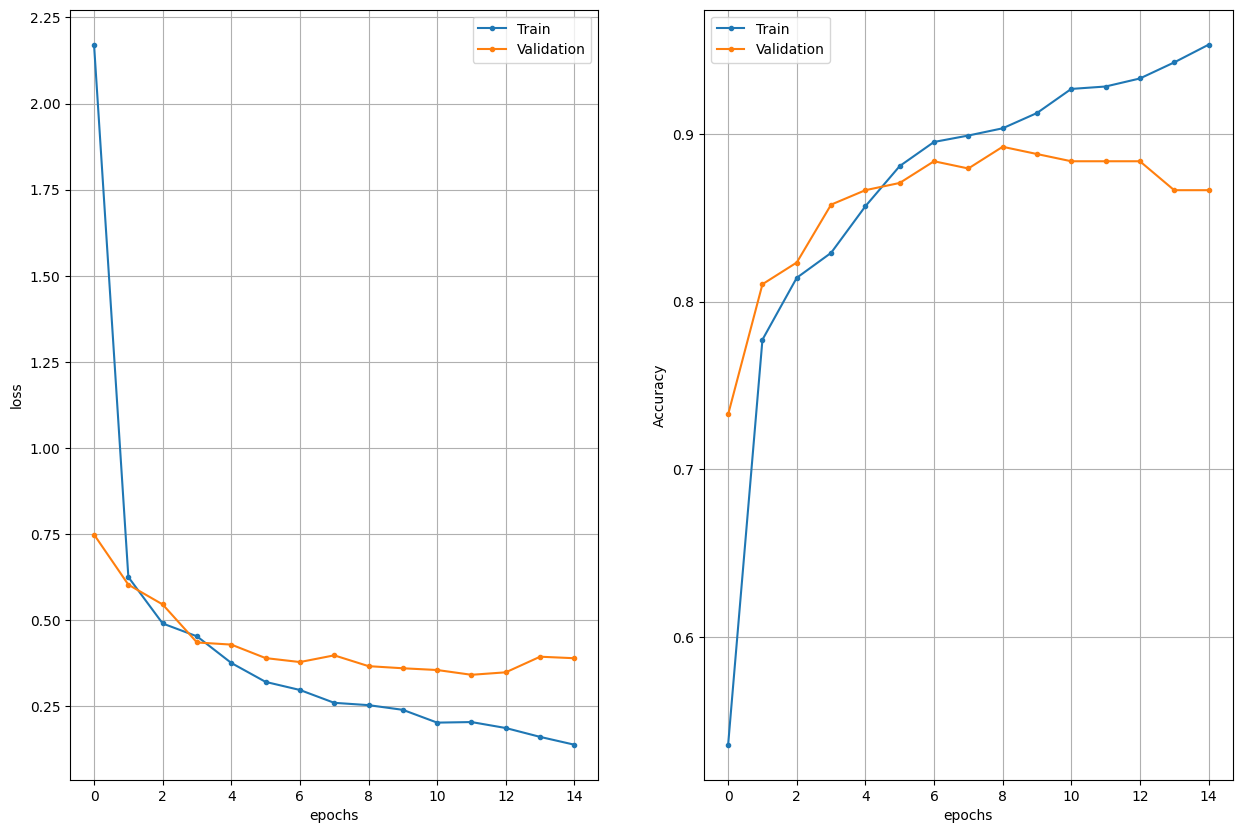

In [18]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

plot_history(history)

In [8]:
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)

print('True', y_true[0:5])
print('Pred', np.argmax(y_pred[0:5, :], axis=1))
print('Pred', y_pred[0:5, :])
print(y_pred.shape)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step
True [36 66 18 37 17]
Pred [36 66 18 37 17]
Pred [[1.54786073e-10 3.94499564e-13 2.02233577e-11 1.87908933e-12
  1.27632585e-10 8.47242155e-12 5.98711081e-11 5.13180227e-11
  2.87073670e-10 2.34279574e-09 2.10622297e-12 1.46435572e-11
  1.19502463e-10 3.36806104e-11 1.00093073e-10 4.18503954e-10
  5.18513661e-12 5.06187731e-11 5.54565116e-10 9.17936893e-10
  4.53504290e-10 3.38105793e-10 2.09337200e-11 5.72045059e-12
  7.14669157e-10 1.26171070e-11 1.31790997e-12 1.03806137e-10
  2.61441396e-10 8.77719342e-10 8.67310057e-10 2.32677853e-12
  1.02409882e-13 5.57973546e-12 2.42676240e-10 2.44318971e-06
  9.98982728e-01 1.42318357e-04 1.74342816e-08 2.26243135e-10
  4.01705492e-12 6.57023210e-13 1.89729850e-08 1.38212054e-05
  8.57478823e-04 1.10157250e-09 6.70964710e-07 1.38828304e-09
  2.29907985e-11 8.54206590e-08 6.38335251e-08 8.94296264e-08
  6.36235731e-09 7.26044988e-11 5.04870321e-12 1.42287941e-08
  3.23369470e-10 2.35618799e-11 6.13439477

Evaluate model

In [9]:
ev = model.evaluate(x_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8294 - loss: 1.0926


In [10]:
print('Test loss  ', ev[0])
print('Test metric', ev[1])

Test loss   1.14693284034729
Test metric 0.8283464312553406


We now visualise some of the evaluation results.

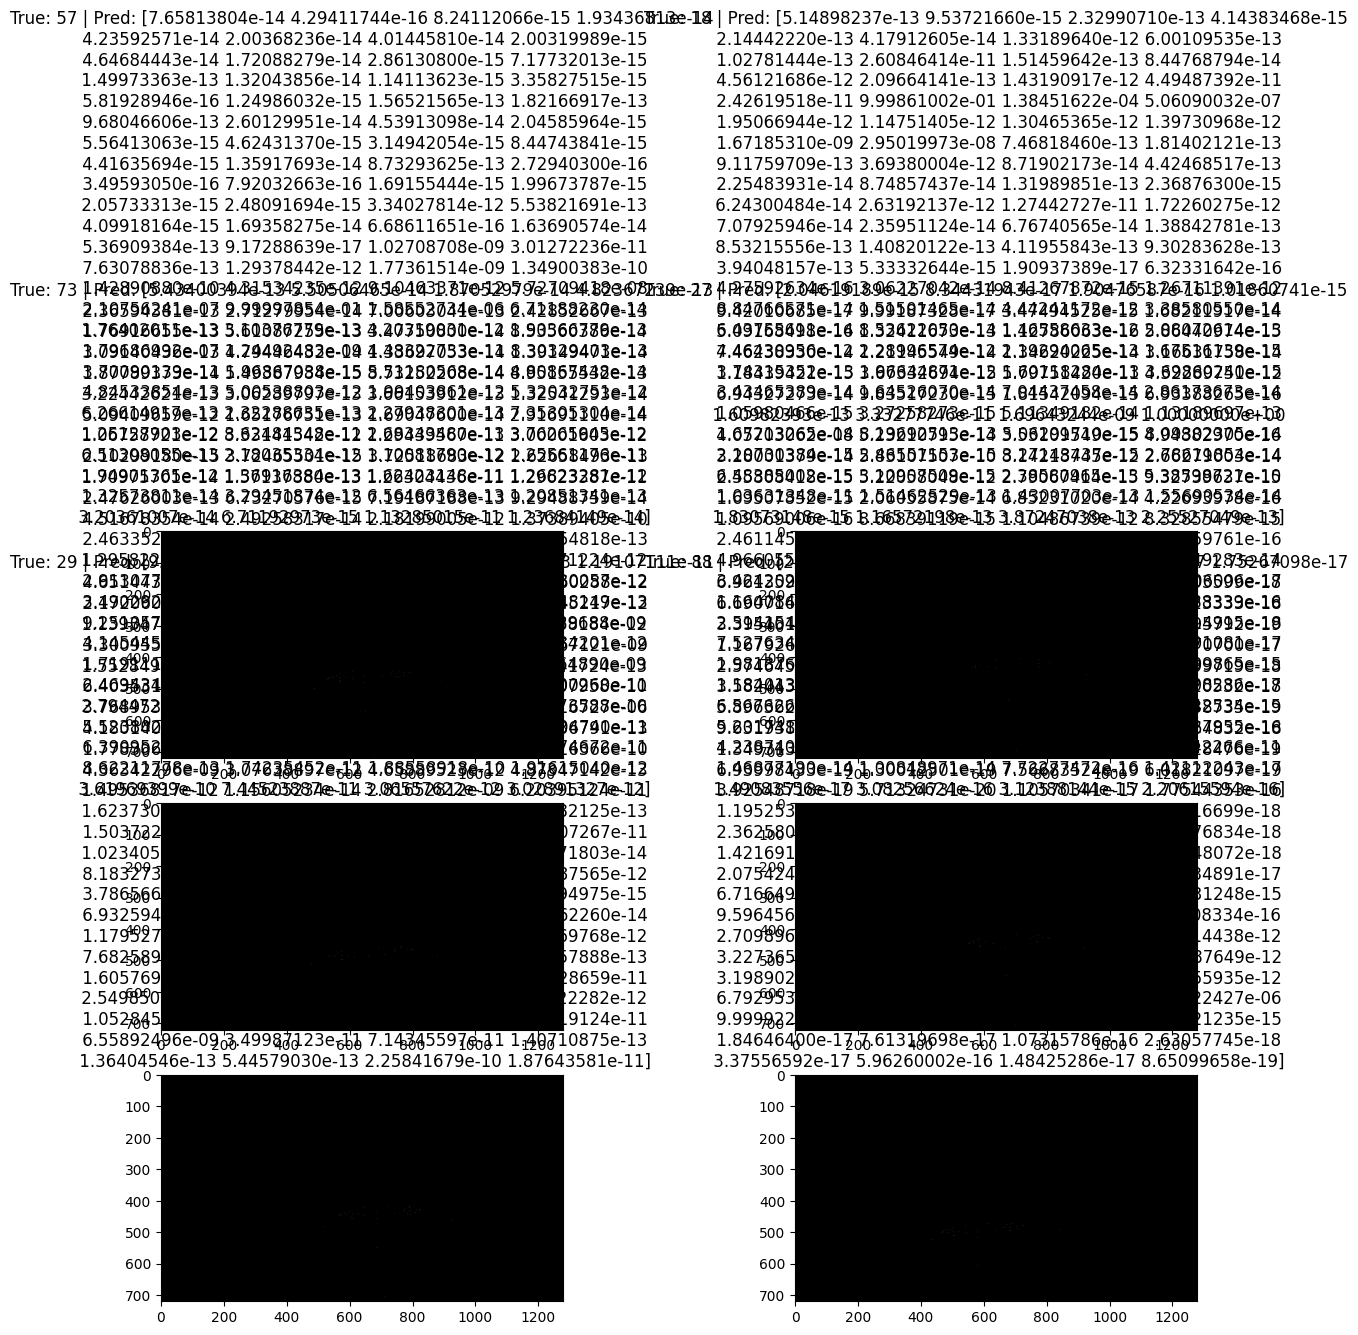

In [11]:
for ii in range(6):
    idx = np.random.randint(0, len(y_pred))
    plt.subplot(3,2,ii+1), plt.imshow(x_test[idx, ...], cmap='gray')
    plt.title('True: ' + str(y_true[idx]) + ' | Pred: ' + '')

In [1]:
import zipfile
import os

zip_path = "gaze_dataset.zip"  # ім'я завантаженого файлу
extract_path = "./"   # куди розпакувати

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))


['.config', 'gaze_dataset', 'gaze_dataset.zip', 'sample_data']
